In [1]:
# import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from alstm import ALSTMModel
from nltk.corpus import stopwords
from text_preprocessor import TextPreprocessor
from training import train_model, evaluate_model
from preprocess import collate_fn, read_dataset, log_model_train_grid_search, plot_model_history, log_report_and_conf_mat,log_model_history, TextClassificationDataset
import os
import time
import numpy as np

[nltk_data] Downloading package punkt to /Users/mfshobur/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mfshobur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mfshobur/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
g = torch.Generator()
g.manual_seed(42)

def create_new_data(use_stopwords, use_stemming, use_lemma):
    """
    Return train, validation, test loader, and text preprocessor
    """
    train_df = read_dataset('../dataset/trec_train.csv')
    train_df = train_df.dropna()
    test_df = read_dataset('../dataset/trec_test.csv')
    test_df = test_df.dropna()

    # drop all abbreviation
    drop_abbreviation=True
    if drop_abbreviation:
        train_df = train_df[train_df['coarse_label'] != 0]
        train_df['coarse_label'] = train_df['coarse_label'].apply(lambda x: x-1)
        test_df = test_df[test_df['coarse_label'] != 0]
        test_df['coarse_label'] = test_df['coarse_label'].apply(lambda x: x-1)
        label_names = ["ENTY", "DESC", "HUM", "LOC", "NUM"]
    else:
        label_names = ["ABBR", "ENTY", "DESC", "HUM", "LOC", "NUM"]

    train_texts = train_df['text'].values
    test_texts = test_df['text'].values

    train_labels = train_df['coarse_label'].values
    test_labels = test_df['coarse_label'].values

    X_test = test_texts
    y_test = test_labels

    # Further split training data into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels
    )

    # Preprocess text data
    # CONFIG
    stop = set(stopwords.words('english'))
    preprocessor = TextPreprocessor(stopwords=stop, max_vocab_size=10000, max_seq_length=50)
    trec_vocab = preprocessor.get_vocab_from_texts(
        [*X_test, *X_val, *X_train],
        use_stopwords=use_stopwords,
        use_lemmatization=use_lemma,
        use_stemming=use_stemming,
    )

    preprocessor.download_model(filter_from_vocab=trec_vocab, save_embedding=True)
    # preprocessor.fit([*X_train, *X_val, *X_test])
    print(f'Jumlah vocabulary/kosa kata: {preprocessor.vocab_size}')

    # Transform texts to sequences
    X_train_seq = preprocessor.transform(X_train, use_stopwords=use_stopwords, use_stemming=use_stemming, use_lemmatization=use_lemma)
    X_val_seq = preprocessor.transform(X_val, use_stopwords=use_stopwords, use_stemming=use_stemming, use_lemmatization=use_lemma)
    X_test_seq = preprocessor.transform(X_test, use_stopwords=use_stopwords, use_stemming=use_stemming, use_lemmatization=use_lemma)

    labels = len(label_names)
    labels_total = train_df['coarse_label'].value_counts().sort_index().values
    # imbalance dataset
    targets = []
    # targets += [[index] * labels_total[index] for index in range(labels)]
    for i in range(labels):
        targets += [i] * labels_total[i]

    # Create datasets
    train_dataset = TextClassificationDataset(X_train_seq, y_train)
    val_dataset = TextClassificationDataset(X_val_seq, y_val)
    test_dataset = TextClassificationDataset(X_test_seq, y_test)

    batch_size=50
    num_workers=0

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
        generator=g)
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        collate_fn=collate_fn)
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        collate_fn=collate_fn)
    
    return train_loader, val_loader, test_loader, preprocessor

In [4]:
# Scenario
scenario = {
    'vocabulary': [None, 'use_stopwords', 'use_stemming', 'use_lemma'],
    'drop_rate': [0.1, 0.3, 0.5],
    'learning_rate': [0.01, 0.001, 0.0001],
    'weight_decay': [0.01, 0.001, 0.0001],
    # 'n_heads': [1, 2, 3, 5, 6, 10, 15, 25, 30, 50, 75, 150],
}

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

label_names = ["ENTY", "DESC", "HUM", "LOC", "NUM"]

Using device: cpu


In [5]:
def update_current_scenario_vocab(active_scenario: dict, current_value):
    if current_value is None:
        for key in active_scenario.keys():
            if 'use' in key:
                active_scenario[key] = False
    else:
        for key in active_scenario.keys():
            if 'use' in key:
                if key == current_value:
                    active_scenario[key] = True
                else:
                    active_scenario[key] = False
    return active_scenario


Scenario 1: {'vocabulary': None, 'drop_rate': 0.1, 'learning_rate': 0.01, 'weight_decay': 0.01}
Jumlah vocabulary/kosa kata: 8898
created new data with intervention: None
Starting training for scenario 1
Test Loss: 1.6114, Test Acc: 0.1914

Classification Report:
              precision    recall  f1-score   support

        ENTY       0.19      1.00      0.32        94
        DESC       0.00      0.00      0.00       138
         HUM       0.00      0.00      0.00        65
         LOC       0.00      0.00      0.00        81
         NUM       0.00      0.00      0.00       113

    accuracy                           0.19       491
   macro avg       0.04      0.20      0.06       491
weighted avg       0.04      0.19      0.06       491


Confusion Matrix:
[[ 94   0   0   0   0]
 [138   0   0   0   0]
 [ 65   0   0   0   0]
 [ 81   0   0   0   0]
 [113   0   0   0   0]]
Test accuracy: 0.1914


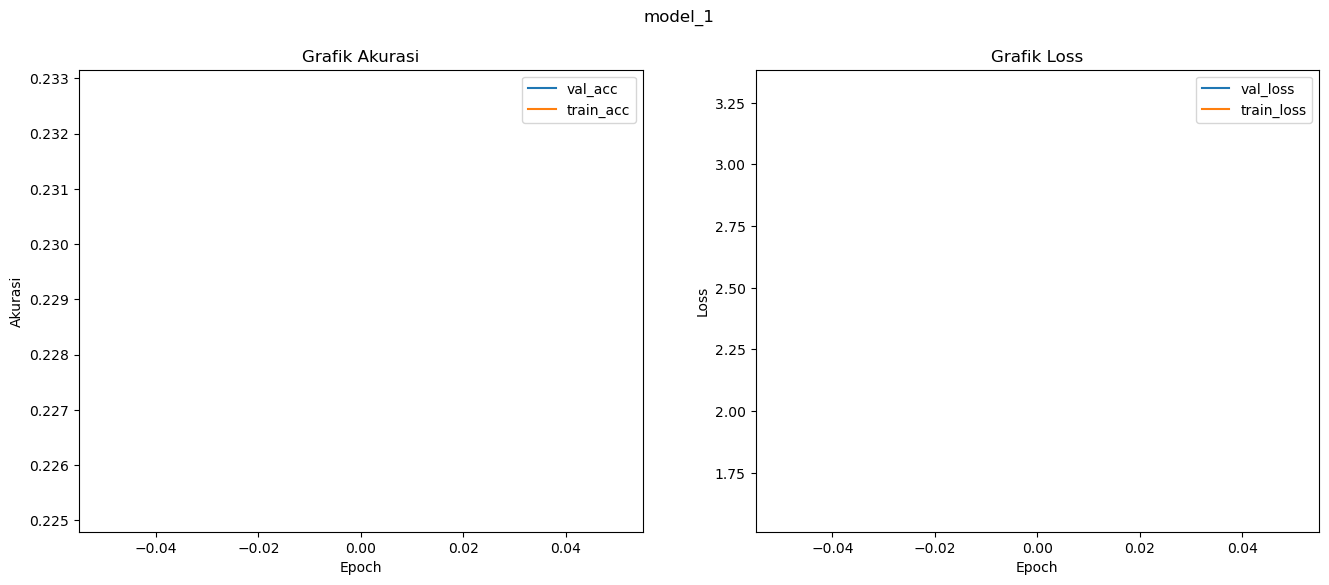

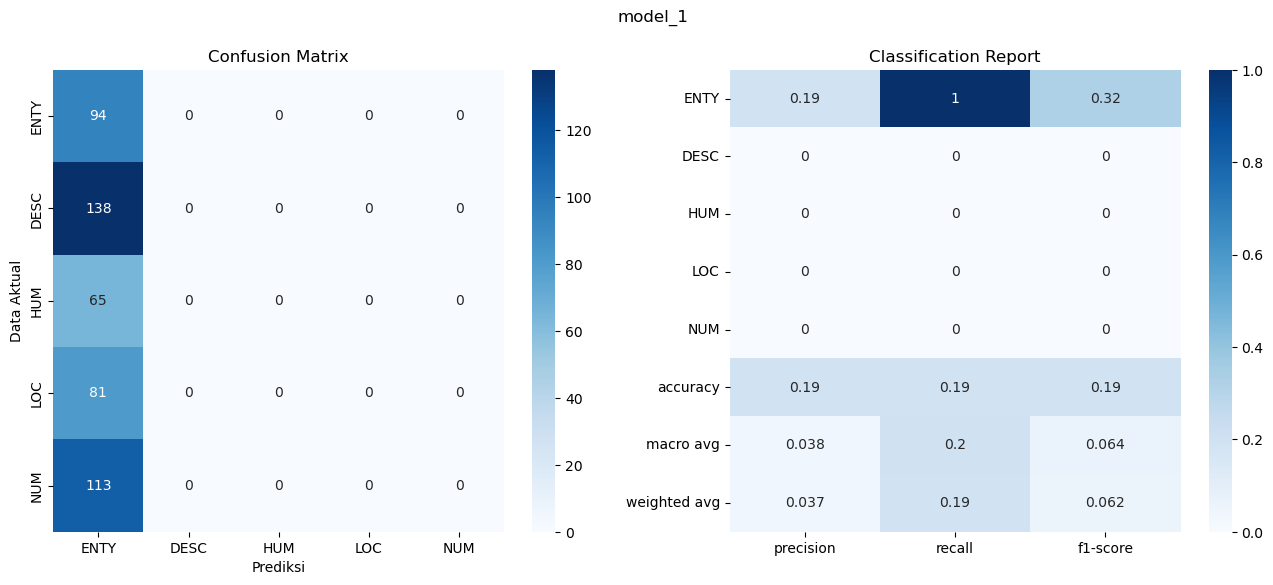

dict_values(['1', '1', 'None', '1', '1', '0.1', '0.01', '0.01', '8898', '1', '0.2252', '0.19144602851323828', '3.2990', '1.611385614954527', '00:04'])
model logged

Scenario 2: {'vocabulary': None, 'drop_rate': 0.1, 'learning_rate': 0.01, 'weight_decay': 0.001}
Starting training for scenario 2
Test Loss: 1.6237, Test Acc: 0.1324

Classification Report:
              precision    recall  f1-score   support

        ENTY       0.00      0.00      0.00        94
        DESC       0.00      0.00      0.00       138
         HUM       0.13      1.00      0.23        65
         LOC       0.00      0.00      0.00        81
         NUM       0.00      0.00      0.00       113

    accuracy                           0.13       491
   macro avg       0.03      0.20      0.05       491
weighted avg       0.02      0.13      0.03       491


Confusion Matrix:
[[  0   0  94   0   0]
 [  0   0 138   0   0]
 [  0   0  65   0   0]
 [  0   0  81   0   0]
 [  0   0 113   0   0]]
Test accuracy: 0.1324

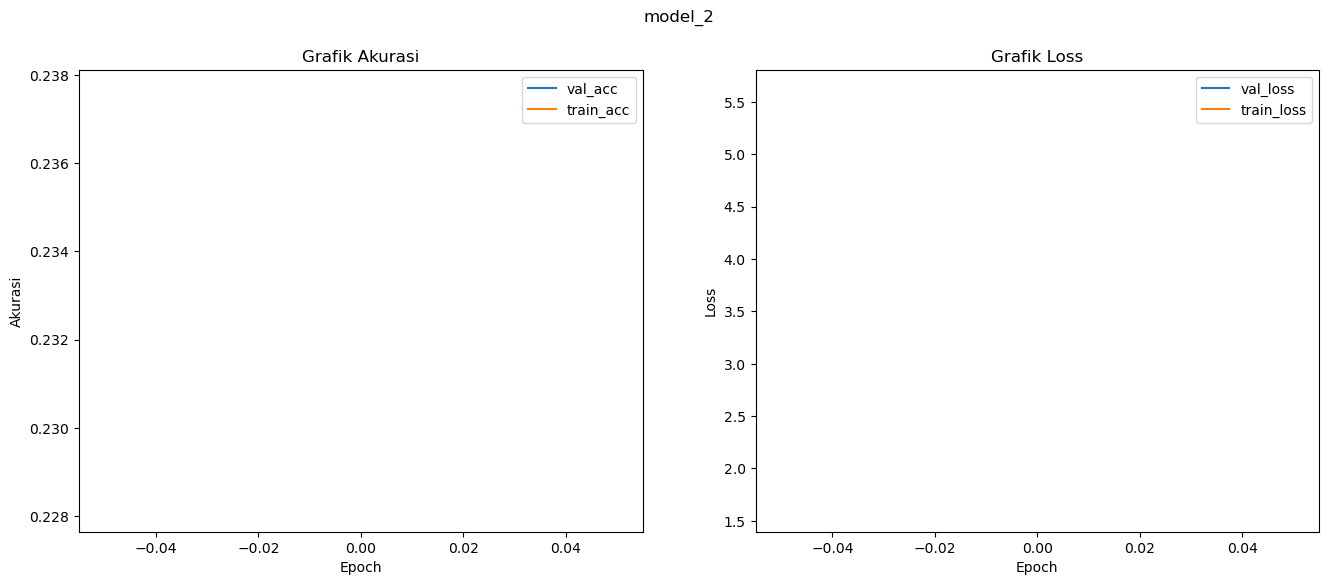

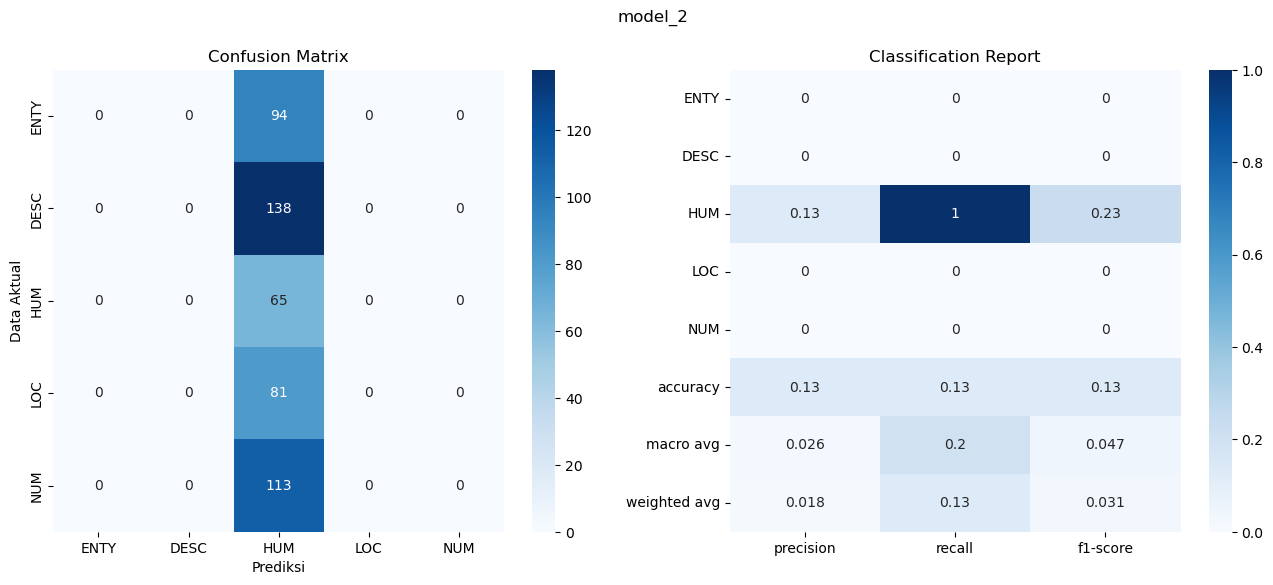

model logged

Scenario 3: {'vocabulary': None, 'drop_rate': 0.1, 'learning_rate': 0.01, 'weight_decay': 0.0001}
Starting training for scenario 3
Test Loss: 1.6270, Test Acc: 0.1914

Classification Report:
              precision    recall  f1-score   support

        ENTY       0.19      1.00      0.32        94
        DESC       0.00      0.00      0.00       138
         HUM       0.00      0.00      0.00        65
         LOC       0.00      0.00      0.00        81
         NUM       0.00      0.00      0.00       113

    accuracy                           0.19       491
   macro avg       0.04      0.20      0.06       491
weighted avg       0.04      0.19      0.06       491


Confusion Matrix:
[[ 94   0   0   0   0]
 [138   0   0   0   0]
 [ 65   0   0   0   0]
 [ 81   0   0   0   0]
 [113   0   0   0   0]]
Test accuracy: 0.1914


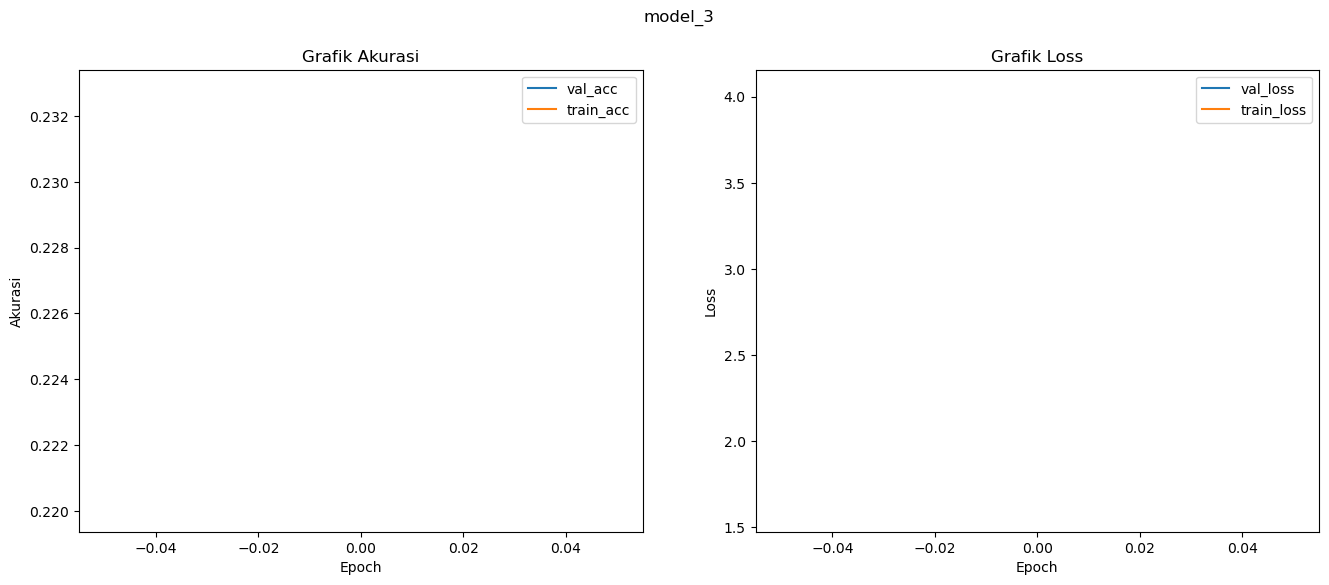

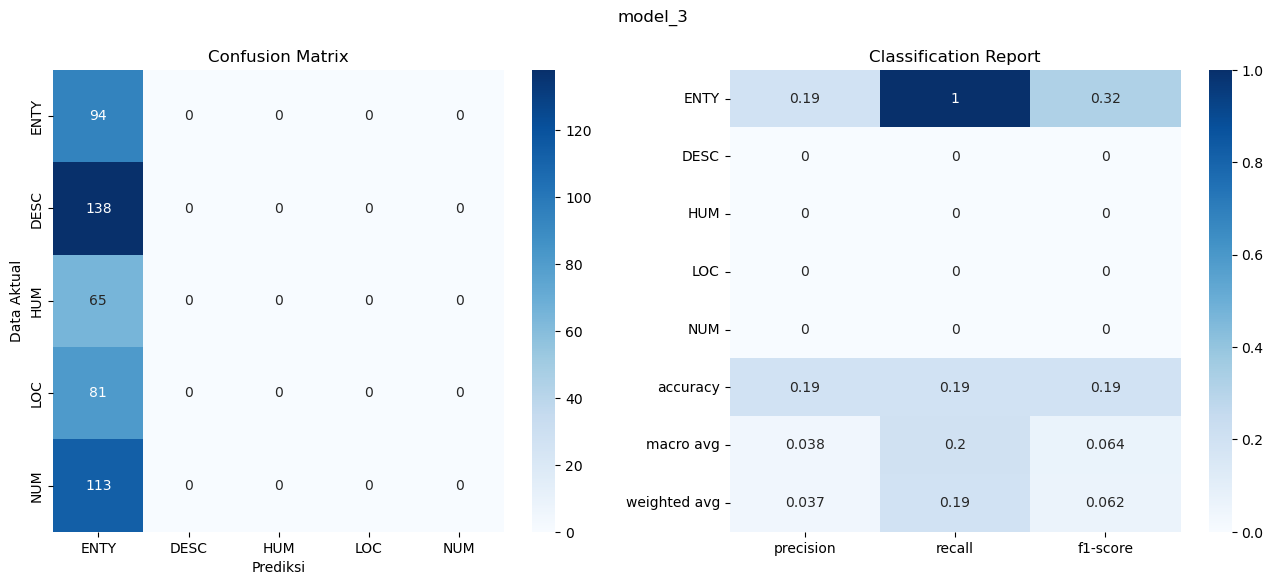

model logged

Scenario 4: {'vocabulary': None, 'drop_rate': 0.1, 'learning_rate': 0.001, 'weight_decay': 0.01}
Starting training for scenario 4
Test Loss: 0.8972, Test Acc: 0.6497

Classification Report:
              precision    recall  f1-score   support

        ENTY       0.57      0.09      0.15        94
        DESC       0.63      0.93      0.75       138
         HUM       0.73      0.85      0.79        65
         LOC       0.89      0.59      0.71        81
         NUM       0.55      0.71      0.62       113

    accuracy                           0.65       491
   macro avg       0.68      0.63      0.60       491
weighted avg       0.66      0.65      0.60       491


Confusion Matrix:
[[  8  40   8   3  35]
 [  0 128   0   0  10]
 [  3   3  55   1   3]
 [  0  14   2  48  17]
 [  3  18  10   2  80]]
Test accuracy: 0.6497


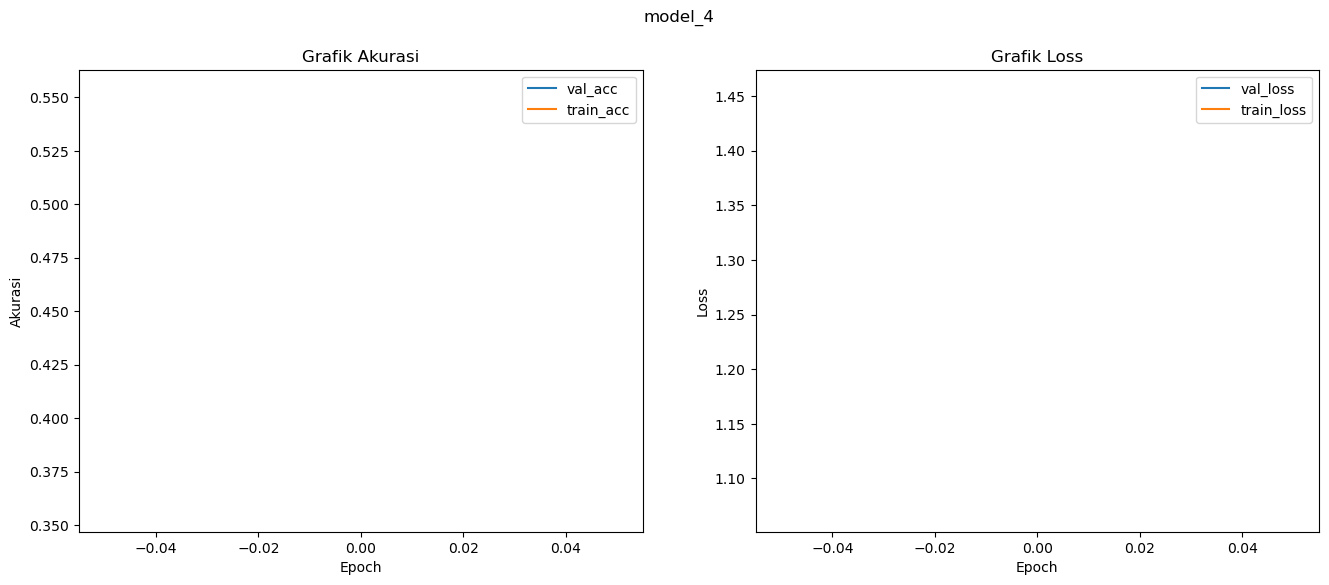

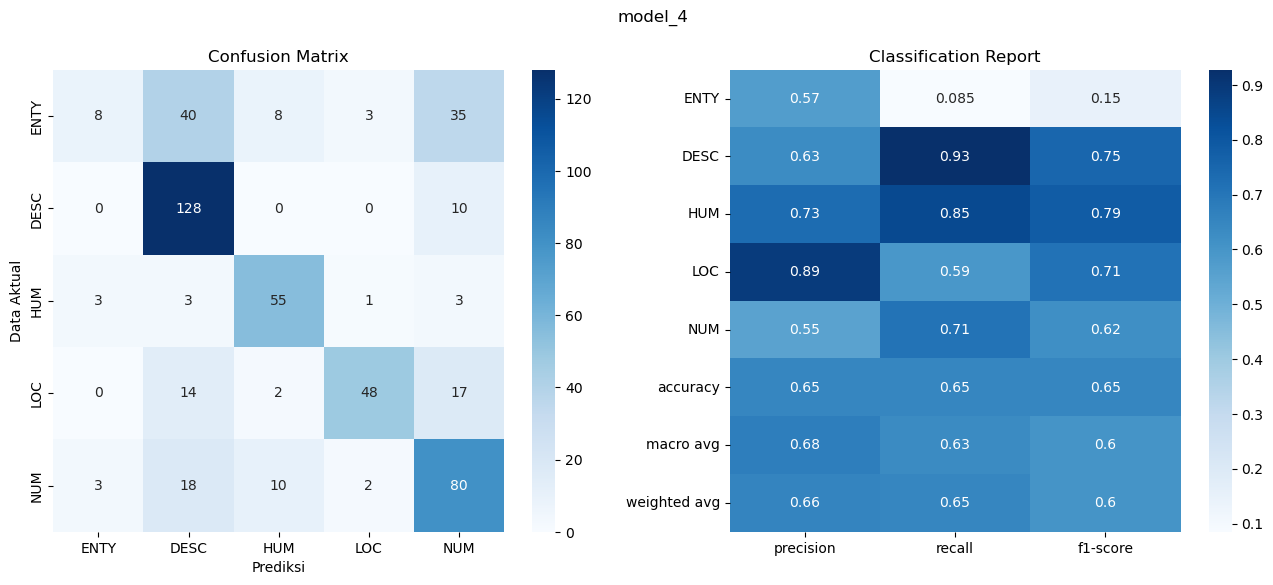

model logged

Scenario 5: {'vocabulary': None, 'drop_rate': 0.1, 'learning_rate': 0.001, 'weight_decay': 0.001}
Starting training for scenario 5
Test Loss: 0.6622, Test Acc: 0.7719

Classification Report:
              precision    recall  f1-score   support

        ENTY       0.65      0.60      0.62        94
        DESC       0.71      0.97      0.82       138
         HUM       0.91      0.82      0.86        65
         LOC       0.87      0.74      0.80        81
         NUM       0.85      0.67      0.75       113

    accuracy                           0.77       491
   macro avg       0.80      0.76      0.77       491
weighted avg       0.78      0.77      0.77       491


Confusion Matrix:
[[ 56  24   4   3   7]
 [  4 134   0   0   0]
 [ 10   1  53   1   0]
 [  9   6   0  60   6]
 [  7  24   1   5  76]]
Test accuracy: 0.7719


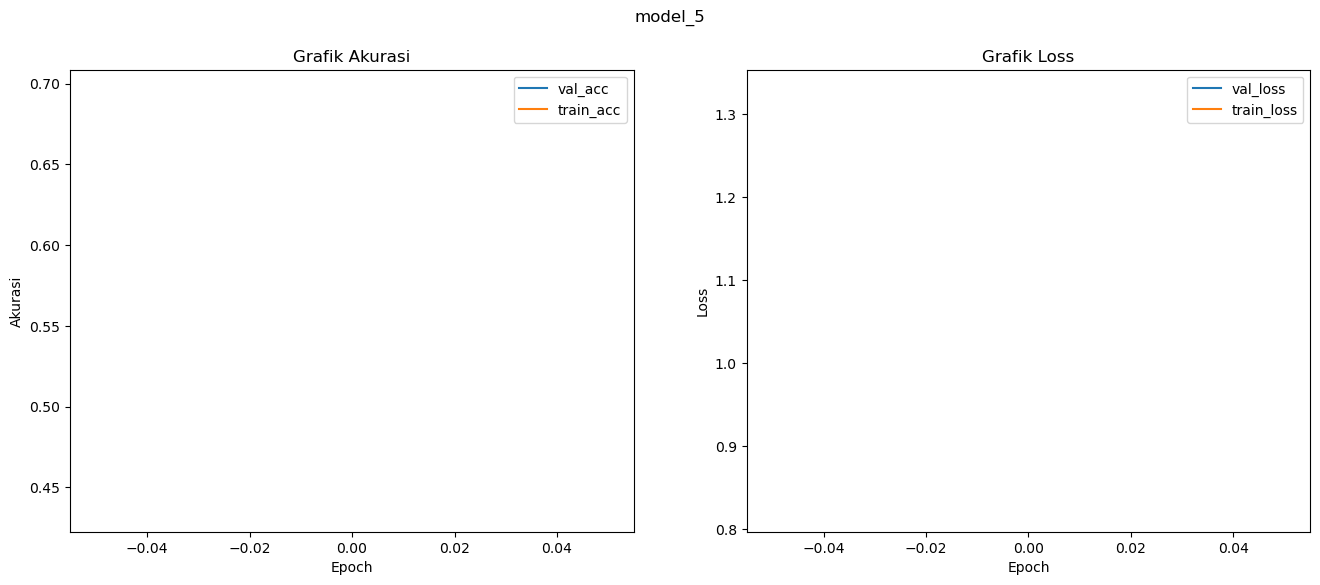

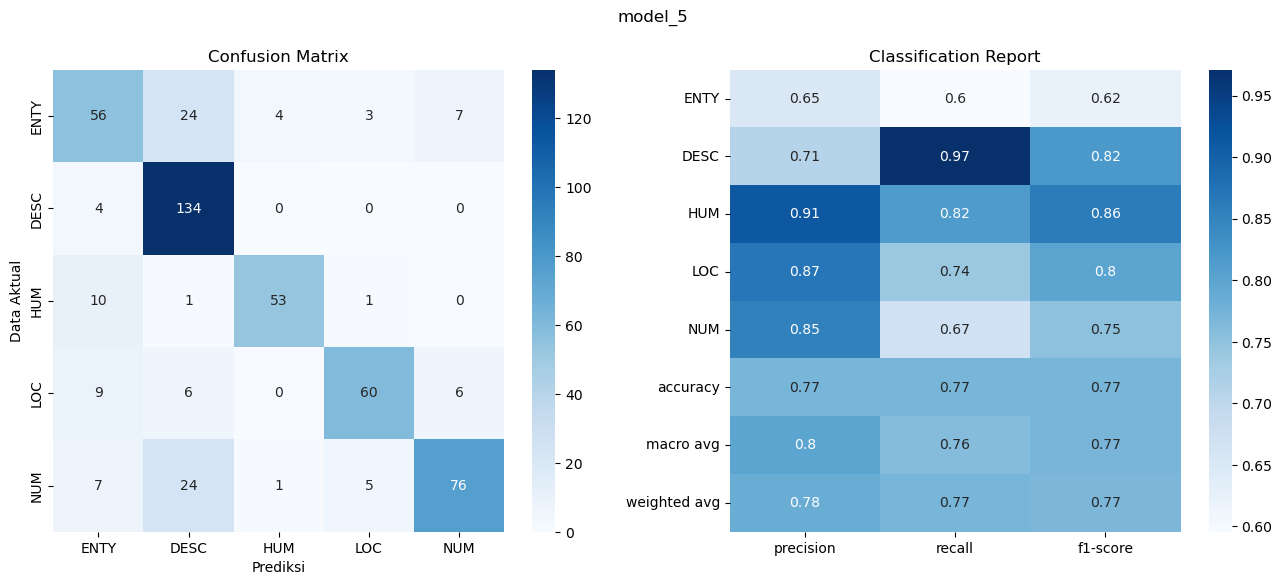

model logged

Scenario 6: {'vocabulary': None, 'drop_rate': 0.1, 'learning_rate': 0.001, 'weight_decay': 0.0001}
Starting training for scenario 6
Test Loss: 0.8456, Test Acc: 0.6477

Classification Report:
              precision    recall  f1-score   support

        ENTY       0.72      0.19      0.30        94
        DESC       0.57      0.99      0.73       138
         HUM       0.74      0.88      0.80        65
         LOC       0.63      0.62      0.62        81
         NUM       0.78      0.50      0.61       113

    accuracy                           0.65       491
   macro avg       0.69      0.64      0.61       491
weighted avg       0.68      0.65      0.61       491


Confusion Matrix:
[[ 18  65   6   3   2]
 [  0 136   0   0   2]
 [  5   2  57   1   0]
 [  1  11   7  50  12]
 [  1  23   7  25  57]]
Test accuracy: 0.6477


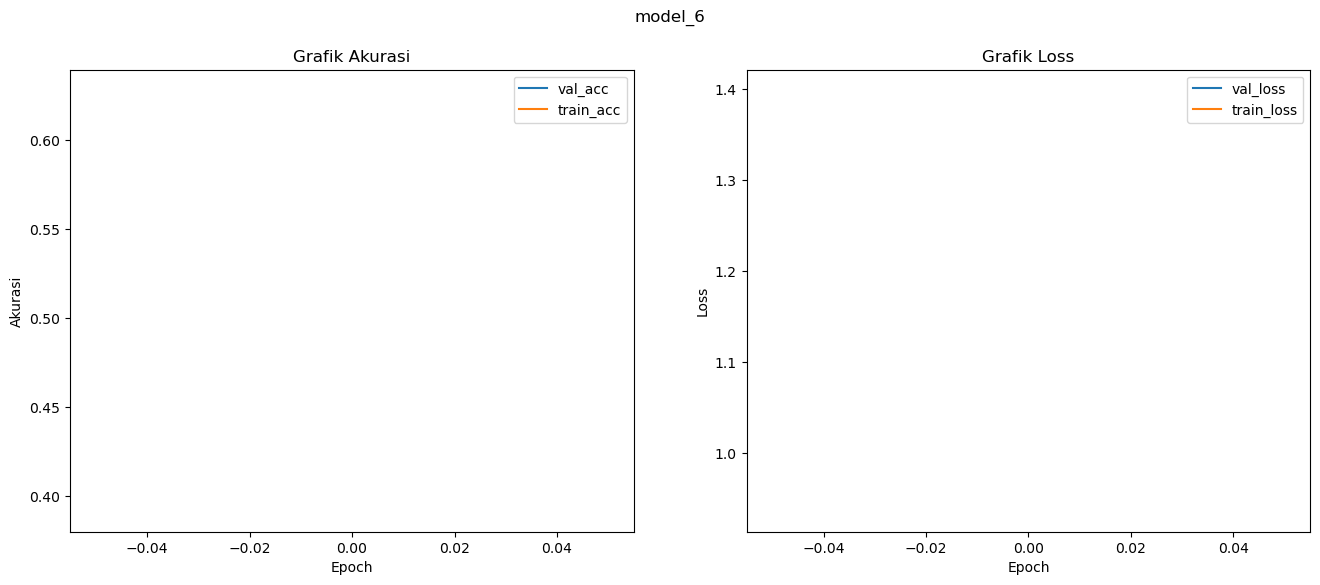

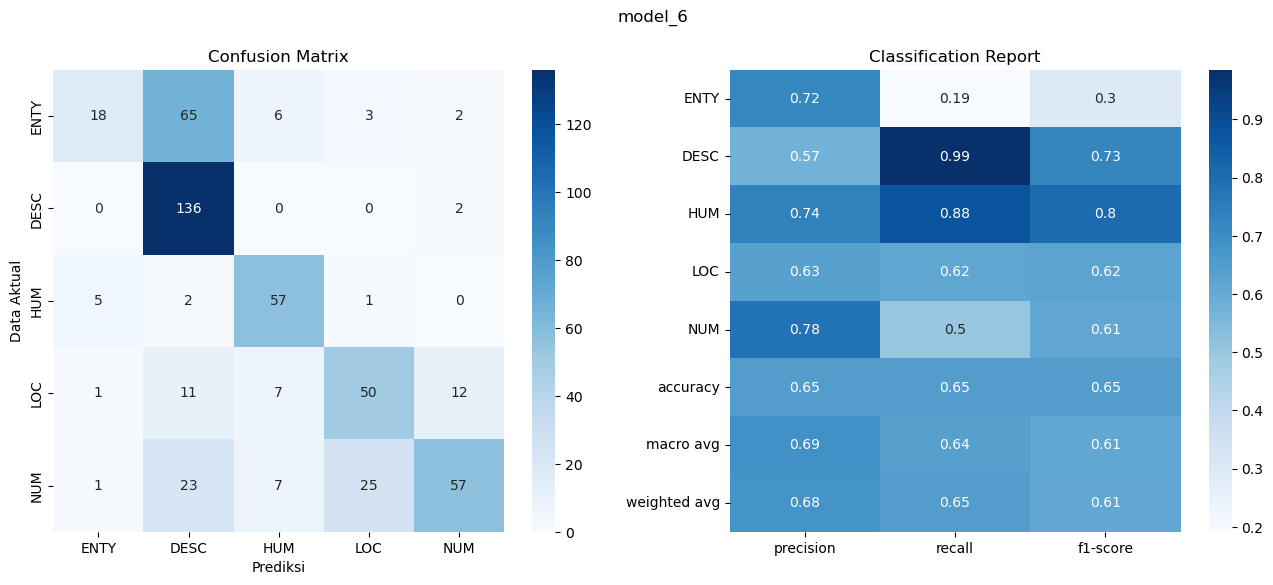

model logged

Scenario 7: {'vocabulary': None, 'drop_rate': 0.1, 'learning_rate': 0.0001, 'weight_decay': 0.01}
Starting training for scenario 7
Test Loss: 1.5436, Test Acc: 0.4623

Classification Report:
              precision    recall  f1-score   support

        ENTY       0.28      0.33      0.30        94
        DESC       0.87      0.75      0.80       138
         HUM       0.37      0.97      0.53        65
         LOC       0.34      0.37      0.35        81
         NUM       0.00      0.00      0.00       113

    accuracy                           0.46       491
   macro avg       0.37      0.48      0.40       491
weighted avg       0.40      0.46      0.41       491


Confusion Matrix:
[[ 31   6  33  24   0]
 [ 21 103   5   9   0]
 [  1   0  63   1   0]
 [ 22   0  29  30   0]
 [ 37  10  41  25   0]]
Test accuracy: 0.4623


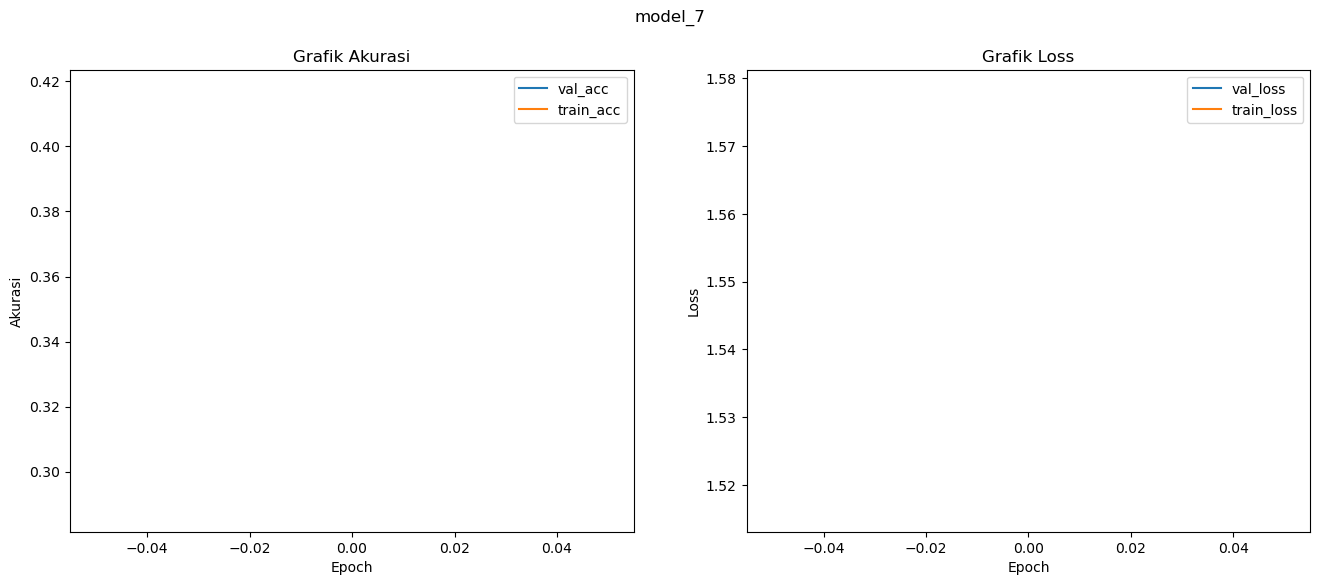

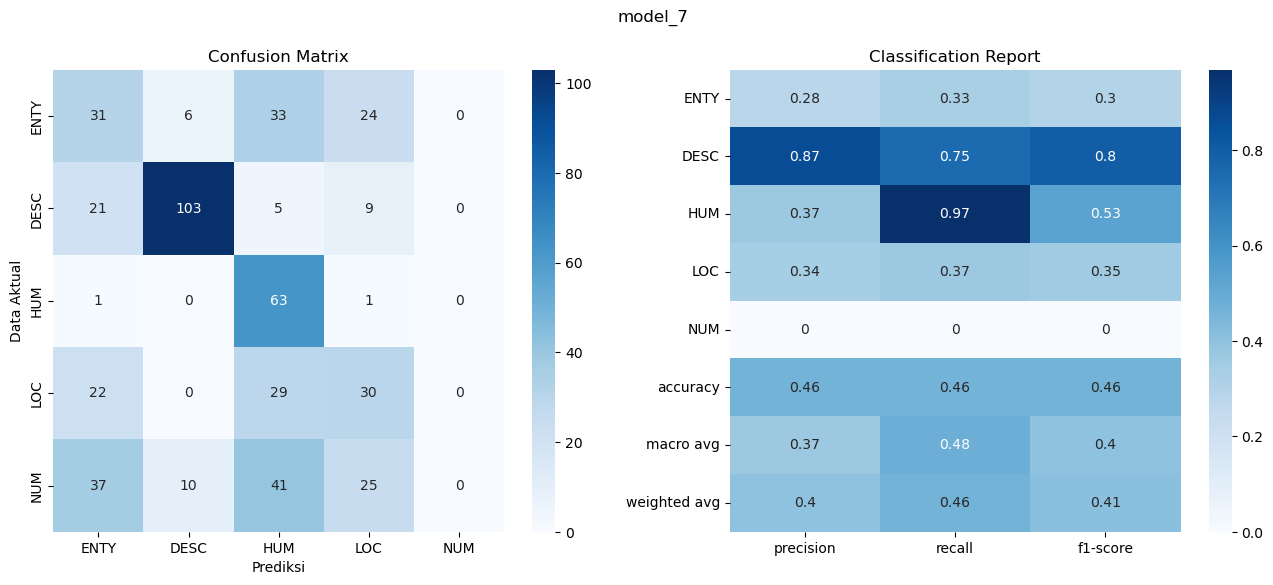

model logged

Scenario 8: {'vocabulary': None, 'drop_rate': 0.1, 'learning_rate': 0.0001, 'weight_decay': 0.001}
Starting training for scenario 8
Test Loss: 1.4409, Test Acc: 0.4521

Classification Report:
              precision    recall  f1-score   support

        ENTY       0.29      0.32      0.31        94
        DESC       0.55      0.90      0.68       138
         HUM       0.40      0.97      0.57        65
         LOC       0.00      0.00      0.00        81
         NUM       0.71      0.04      0.08       113

    accuracy                           0.45       491
   macro avg       0.39      0.45      0.33       491
weighted avg       0.43      0.45      0.34       491


Confusion Matrix:
[[ 30  38  26   0   0]
 [ 13 124   1   0   0]
 [  0   2  63   0   0]
 [ 28  22  29   0   2]
 [ 31  39  38   0   5]]
Test accuracy: 0.4521


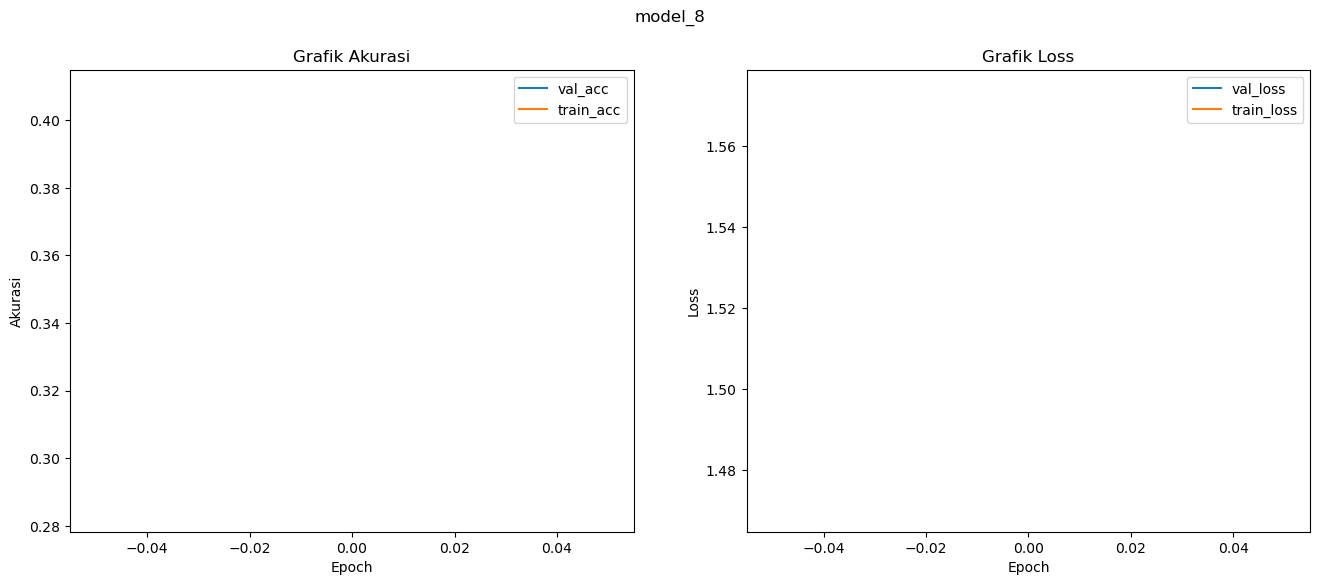

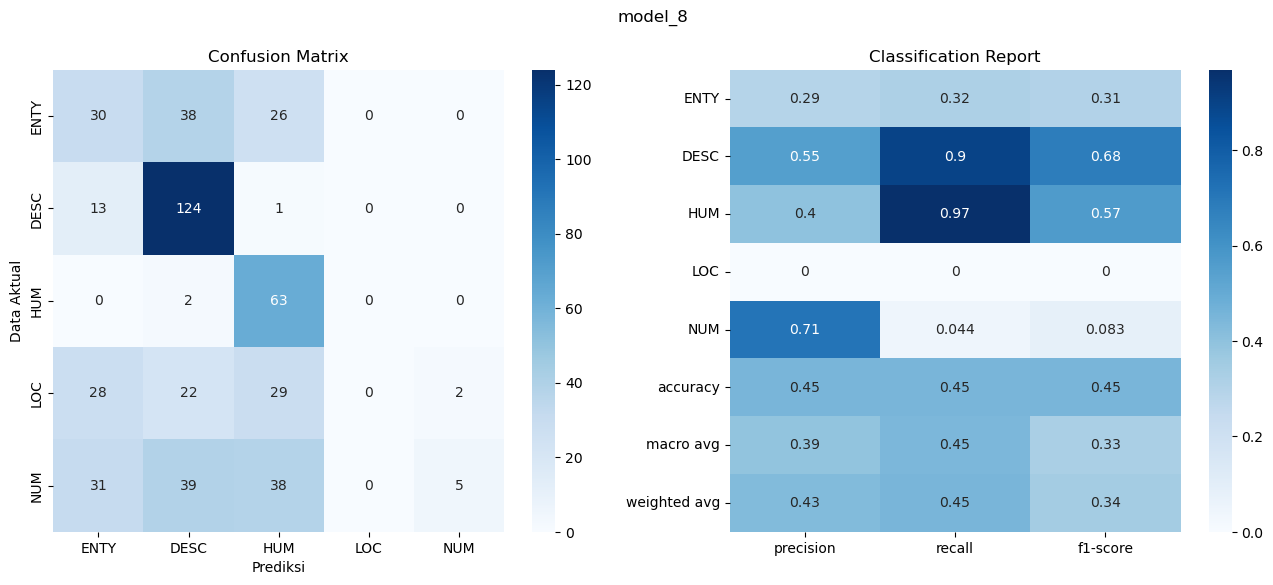

model logged

Scenario 9: {'vocabulary': None, 'drop_rate': 0.1, 'learning_rate': 0.0001, 'weight_decay': 0.0001}
Starting training for scenario 9
Test Loss: 1.4441, Test Acc: 0.4297

Classification Report:
              precision    recall  f1-score   support

        ENTY       0.46      0.17      0.25        94
        DESC       0.41      0.99      0.58       138
         HUM       0.50      0.72      0.59        65
         LOC       0.00      0.00      0.00        81
         NUM       0.44      0.11      0.17       113

    accuracy                           0.43       491
   macro avg       0.36      0.40      0.32       491
weighted avg       0.37      0.43      0.33       491


Confusion Matrix:
[[ 16  64   9   0   5]
 [  1 136   0   0   1]
 [  8  10  47   0   0]
 [  5  55  12   0   9]
 [  5  70  26   0  12]]
Test accuracy: 0.4297


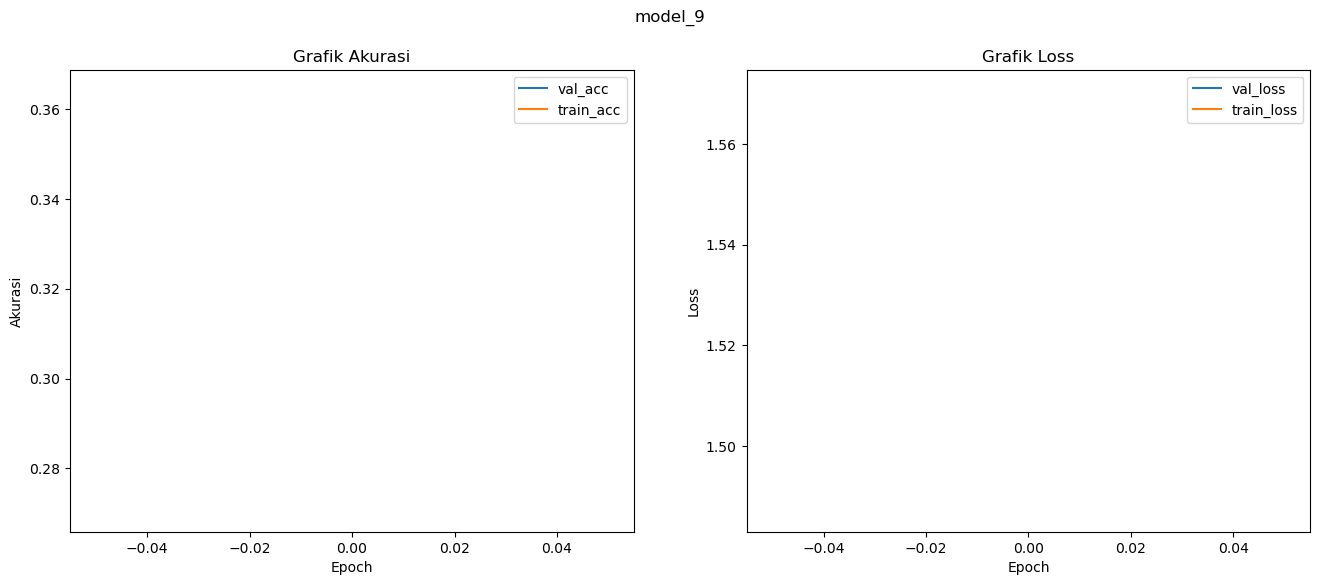

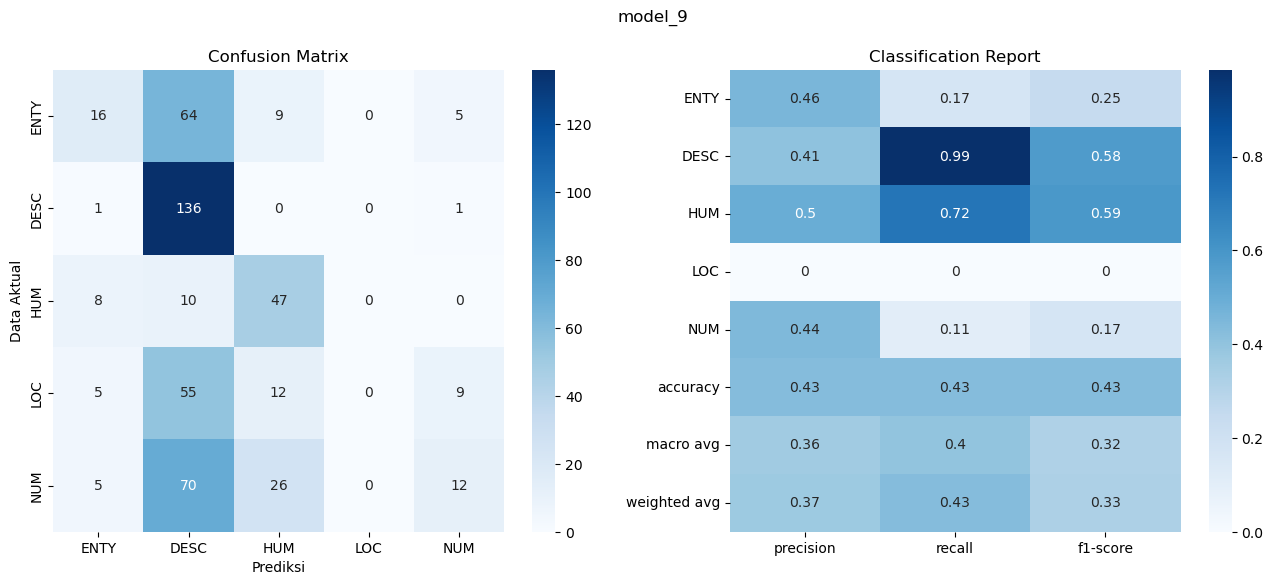

model logged

Scenario 10: {'vocabulary': None, 'drop_rate': 0.3, 'learning_rate': 0.01, 'weight_decay': 0.01}
Starting training for scenario 10


KeyboardInterrupt: 

In [6]:
# Grid search across all combinations
from itertools import product

# Get all combinations of hyperparameters
param_keys = list(scenario.keys())
param_values = list(product(*scenario.values()))

no = 0
folder = 'gridsearch'
csv_path = f'{folder}/gridsearch.csv'
if not os.path.exists(folder):
    os.mkdir(folder)

current_vocabulary = None
previous_vocabulary = ''

for i, param_set in enumerate(param_values):
    folder_path = f'{folder}/{i+1}'
    os.makedirs(folder_path, exist_ok=True)

    param_dict = dict(zip(param_keys, param_set))
    print(f"\nScenario {i+1}: {param_dict}")

    if param_dict['vocabulary'] == 'use_stopwords':
        active_scenario['use_stopwords'] = True
    elif param_dict['vocabulary'] == 'use_stemming':
        active_scenario['use_stemming'] = True
    elif param_dict['vocabulary'] == 'use_lemma':
        active_scenario['use_lemma'] = True

    active_scenario = {
        'drop_rate': param_dict['drop_rate'],
        'learning_rate': param_dict['learning_rate'],
        'weight_decay': param_dict['weight_decay'],
        'n_heads': 1,
        'epoch': 1,
        'use_stopwords': False,
        'use_lemma': False,
        'use_stemming': False,
    }

    # track current vcocabulary
    current_vocabulary = param_dict['vocabulary']

    # if current vocab is different than previous, create new data
    if current_vocabulary != previous_vocabulary:
        active_scenario = update_current_scenario_vocab(active_scenario, current_vocabulary)
        train_loader, val_loader, test_loader, preprocessor = create_new_data(
            use_stopwords=active_scenario['use_stopwords'],
            use_lemma=active_scenario['use_lemma'],
            use_stemming=active_scenario['use_stemming'],
        )
        print('created new data with intervention:', param_dict['vocabulary'])

    cfg = {
        'drop_rate': active_scenario['drop_rate'],
        'output': 5,
        'bidirectional': True,
        'vocab_size': preprocessor.vocab_size,
        'context_length': 100,
        'emb_dim': 300,
        'hidden_size': 150,
        'qkv_bias': False,
        'n_heads': active_scenario['n_heads'],
        'device': device,
        'lstm_layers': 1,
    }

    model = ALSTMModel(cfg).to(device)
    model.embedding.weight.data.copy_(torch.from_numpy(preprocessor.embedding_matrix))
    model.embedding.weight.requires_grad = False

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=active_scenario['learning_rate'], weight_decay=active_scenario['weight_decay'])

    model_name = f"model_{i+1}"
    best_model_path = f"{folder_path}/{model_name}.pt"

    print(f"Starting training for scenario {i+1}")
    start_train = time.time()

    history = train_model(
        model=model,
        train_loader=train_loader,
        valid_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        num_epochs=active_scenario['epoch'],
        log=False,
        best_model_path=best_model_path,
    )

    total_train = time.time() - start_train
    formatted_time = f"{int(total_train) // 60:02d}:{int(total_train) % 60:02d}"

    model.load_state_dict(torch.load(best_model_path))
    model.to(device)

    test_loss, test_acc, report, conf_mat = evaluate_model(
        model=model,
        test_loader=test_loader,
        criterion=criterion,
        device=device,
        label_names=label_names,
        return_report=True
    )

    print(f"Test accuracy: {test_acc:.4f}")

    plot_model_history(
        history=history,
        title=model_name,
        save_path=f'{folder_path}/train_test_graph.png'
    )

    log_model_history(
        history,
        save_path=f'{folder_path}/train_valid_log.csv'
    )

    log_report_and_conf_mat(
        title=model_name,
        report=report,
        confusion_matrix=conf_mat,
        label_names=label_names,
        save_path=f'{folder_path}/classification_report_and_confusion_matrix.png'
    )

    log_model_train_grid_search(
        scenario_num=i+1,
        epoch=active_scenario['epoch'],
        total_epoch=len(history['train_accs']),
        drop_rate=active_scenario['drop_rate'],
        learning_rate=active_scenario['learning_rate'],
        weight_decay=active_scenario['weight_decay'],
        vocabulary=param_dict['vocabulary'],
        n_heads=active_scenario['n_heads'],
        vocabulary_total=preprocessor.vocab_size,
        train_acc=f"{history['train_accs'][-1]:.4f}",
        test_acc=test_acc,
        train_loss=f"{history['train_losses'][-1]:.4f}",
        test_loss=test_loss,
        time=formatted_time,
        file=csv_path,
    )

    del model
    del optimizer
    # delete model weights
    os.remove(best_model_path)
    previous_vocabulary = current_vocabulary

print("\nGrid search completed.")